In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score


import torch

In [28]:
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=1.0, random_state=42)
X_t = torch.tensor(X, dtype=torch.float32)

In [29]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42)
labels_km = kmeans.fit_predict(X)
centroids_km = kmeans.cluster_centers_
score_km = silhouette_score(X, labels_km)


print('[KMEANS | sklearn] Silhouette:', score_km)

[KMEANS | sklearn] Silhouette: 0.7915830011443039


In [30]:
def kmeans_pp_init(X, K):
  N = X.shape[0]
  centroids = [X[torch.randint(0, N, (1,))]]
  for _ in range(1, K):
    d2 = torch.min(torch.stack([torch.sum((X - c)**2, dim=1) for c in centroids]), dim=0)[0]
    probs = d2 / torch.sum(d2)
    idx = torch.multinomial(probs, 1)
    centroids.append(X[idx])
  return torch.cat(centroids)

def kmeans_torch(X, K, iters=100):
  C = kmeans_pp_init(X, K)
  for _ in range(iters):
    dist = torch.cdist(X, C)
    labels = torch.argmin(dist, dim=1)
    newC = torch.stack([X[labels == k].mean(0) for k in range(K)])
    if torch.allclose(C, newC, atol=1e-4): break
    C = newC
  return C, labels


C_km_t, labels_km_t = kmeans_torch(X_t, 4)

In [31]:
from sklearn.cluster import DBSCAN


db = DBSCAN(eps=0.6, min_samples=5)
labels_db = db.fit_predict(X)


if len(set(labels_db)) > 1:
  print('[DBSCAN | sklearn] Silhouette:', silhouette_score(X, labels_db))

[DBSCAN | sklearn] Silhouette: 0.434559386864339


In [32]:
def dbscan_torch(X, eps, min_pts):
  N = X.shape[0]
  labels = -torch.ones(N, dtype=torch.long)
  cluster_id = 0
  dist = torch.cdist(X, X)


  for i in range(N):
    if labels[i] != -1: continue
    neighbors = (dist[i] <= eps).nonzero().flatten()
    if len(neighbors) < min_pts:
      labels[i] = -2 # noise
      continue
    labels[i] = cluster_id
    stack = list(neighbors.numpy())
    while stack:
      j = stack.pop()
      if labels[j] == -2:
        labels[j] = cluster_id
      if labels[j] != -1: continue
      labels[j] = cluster_id
      nb = (dist[j] <= eps).nonzero().flatten()
      if len(nb) >= min_pts:
        stack.extend(nb.numpy())
    cluster_id += 1
  return labels


labels_db_t = dbscan_torch(X_t, eps=0.6, min_pts=5)

In [33]:
from sklearn.cluster import AgglomerativeClustering


agg = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels_ag = agg.fit_predict(X)
print('[AGGLOMERATIVE | sklearn] Silhouette:', silhouette_score(X, labels_ag))

[AGGLOMERATIVE | sklearn] Silhouette: 0.7915830011443039


In [34]:
def agglomerative_single_link(X, K):
  clusters = [[i] for i in range(len(X))]
  dist = torch.cdist(X, X)


  while len(clusters) > K:
    min_d, pair = 1e9, None
    for i in range(len(clusters)):
        for j in range(i+1, len(clusters)):
          d = min(dist[a, b] for a in clusters[i] for b in clusters[j])
          if d < min_d:
            min_d, pair = d, (i, j)
    i, j = pair
    clusters[i] += clusters[j]
    clusters.pop(j)


  labels = torch.zeros(len(X), dtype=torch.long)
  for idx, c in enumerate(clusters):
    for i in c:
      labels[i] = idx
  return labels


labels_ag_t = agglomerative_single_link(X_t, 4)

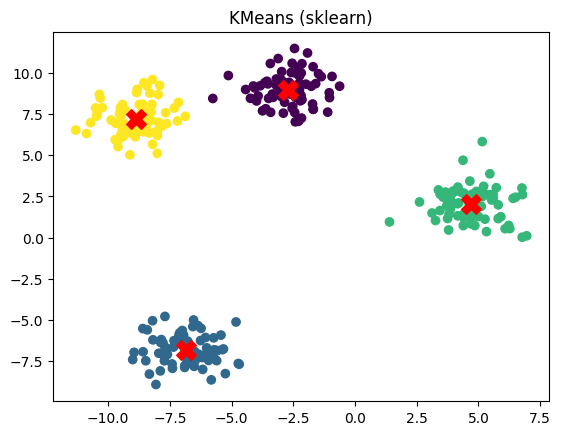

In [35]:
plt.scatter(X[:,0], X[:,1], c=labels_km, cmap='viridis')
plt.scatter(centroids_km[:,0], centroids_km[:,1], c='red', s=200, marker='X')
plt.title('KMeans (sklearn)')
plt.show()